Analyses properties of decorrelation and whitening methods for decorrelated networks

In [1]:
import numpy as np
import torch
import torch.nn as nn
from decorrelation.decorrelation import Decorrelation, DecorLinear, DecorConv2d, lower_triangular, decor_modules
import matplotlib.pyplot as plt
import matplotlib
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from decorrelation.train import decor_train
import argparse

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def plot_results(init_model, model, dataloader):

    for batch in dataloader:
        init_model.forward(batch[0].to(device))
        model.forward(batch[0].to(device))
        init_modules = decor_modules(init_model)
        modules = decor_modules(model)
        for i, (imod, mod) in enumerate(zip(init_modules, modules)):
        
            state = imod.decor_state            
            Ci = (state.T @ state) / len(state)
            Ci = Ci.detach().numpy()

            state = mod.decor_state            
            C = (state.T @ state) / len(state)
            C = C.detach().numpy()

            plt.subplot(2, len(modules), i+1)
            plt.title(f'layer {i+1}')
            plt.xlabel('$x_i x_j$')
            plt.hist([lower_triangular(Ci, offset=-1), lower_triangular(C, offset=-1)], bins=30, label=['correlated', 'decorrelated'])
            plt.subplot(2, len(modules), i+1+len(modules))
            plt.hist([np.diagonal(Ci), np.diagonal(C)], bins=30, label=['correlated', 'decorrelated'])
            plt.xlabel('$x_i^2$')
            print(f'layer {i+1} mean covariance before decorrelation: {np.mean(lower_triangular(Ci, offset=-1)):.2f}')
            print(f'layer {i+1} mean covariance after decorrelation: {np.mean(lower_triangular(C, offset=-1)):.2f}')
            print(f'layer {i+1} mean variance before decorrelation: {np.mean(np.diagonal(Ci)):.2f}')
            print(f'layer {i+1} mean variance after decorrelation: {np.mean(np.diagonal(C)):.2f}')
        break
    plt.legend();

In [13]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(1),
        transforms.Normalize((0.5), (0.25)),
        # torch.flatten # not necessary but useful for debugging
        ])

train_data = MNIST(root='~/Data', train=True, download=True, transform=transform)
train_data = Subset(train_data, np.random.permutation(len(train_data.data))[:1000])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0, drop_last=True)

In [11]:
args = argparse.Namespace(lr=1e-4, eta=0.3, decor_lr=1e-3, whiten=True, epochs=30) # NOTE: Fails for whiten=True

class Model(nn.Sequential):
    def __init__(self, in_features, eta, whiten):
        super().__init__(DecorLinear(in_features, 100, decor_bias=False, eta=eta, whiten=whiten),
                        nn.LeakyReLU(),
                        DecorLinear(100, 10, decor_bias=False, eta=eta, whiten=whiten)
                        )

    def forward(self, x):
        return super().forward(x.view(len(x), -1))

model = Model(784, eta=args.eta, whiten=args.whiten).to(device)

lossfun = torch.nn.CrossEntropyLoss().to(device)

res = decor_train(args, model, lossfun, train_loader, device)

epoch 0  	time:0.000 s	bp loss: 2.585367	decorrelation loss: 109.834946
epoch 1  	time:0.525 s	bp loss: 2.450903	decorrelation loss: 15.885253
epoch 2  	time:0.466 s	bp loss: 2.241629	decorrelation loss: 0.877338
epoch 3  	time:0.502 s	bp loss: 2.029726	decorrelation loss: 0.817087
epoch 4  	time:0.518 s	bp loss: 1.854118	decorrelation loss: 1.421555
epoch 5  	time:0.519 s	bp loss: 1.712593	decorrelation loss: 7.451248
epoch 6  	time:0.470 s	bp loss: 1.608016	decorrelation loss: 23.947058
epoch 7  	time:0.582 s	bp loss: 1.463510	decorrelation loss: 42.235283
epoch 8  	time:0.591 s	bp loss: 1.360451	decorrelation loss: 101.862724
epoch 9  	time:0.435 s	bp loss: 1.281573	decorrelation loss: 154.583191
epoch 10 	time:0.481 s	bp loss: 1.209458	decorrelation loss: 310.420380
epoch 11 	time:0.559 s	bp loss: 1.111046	decorrelation loss: 240.515167
epoch 12 	time:0.456 s	bp loss: 1.049586	decorrelation loss: 389.561157
epoch 13 	time:0.462 s	bp loss: 1.027904	decorrelation loss: 461.050598
epo

layer 1 mean covariance before decorrelation: 2.20
layer 1 mean covariance after decorrelation: -0.01
layer 1 mean variance before decorrelation: 3.69
layer 1 mean variance after decorrelation: 31.71
layer 2 mean covariance before decorrelation: 0.13
layer 2 mean covariance after decorrelation: 1.04
layer 2 mean variance before decorrelation: 0.47
layer 2 mean variance after decorrelation: 15.74


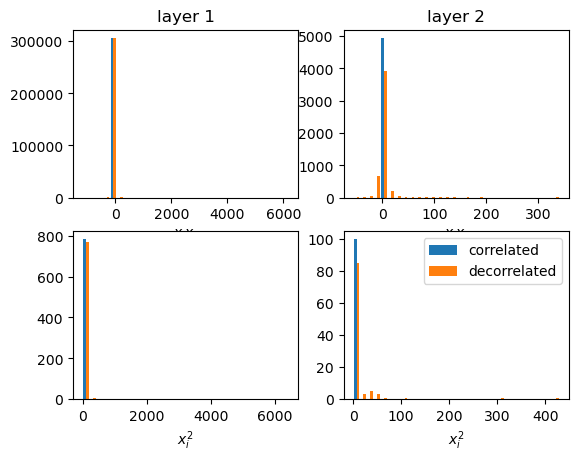

In [12]:
init_model = Model(784, eta=args.eta, whiten=args.whiten).to(device) # deepcopy does not work
plot_results(init_model, model, train_loader)